<a href="https://colab.research.google.com/github/TheAlchemist010/DeepLearning-Notebooks/blob/main/Notebook4AssignmentKaggleCompetition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle competition for Assignment 1

### <span style="color:#0b486b"> II.0 Running on Google Colab</span> <span style="color:red"></span>
You will need to download relevant files to run this notebook on Google Colab.

In [1]:
!gdown --fuzzy https://drive.google.com/file/d/1aEkxNWaD02Z8ZNvZzeMefUoY97C-3wTG/view?usp=drive_link

Downloading...
From (original): https://drive.google.com/uc?id=1aEkxNWaD02Z8ZNvZzeMefUoY97C-3wTG
From (redirected): https://drive.google.com/uc?id=1aEkxNWaD02Z8ZNvZzeMefUoY97C-3wTG&confirm=t&uuid=ca8c70e6-43af-4c01-9be4-f278dd8d217e
To: /content/Animals_Dataset.zip
100% 643M/643M [00:05<00:00, 125MB/s]


Backup link for the training set.

In [2]:
!gdown --fuzzy https://drive.google.com/file/d/1sRH3l1p5HzSFSGo3x3NfQ_EUn7AQ5JFC/view?usp=sharing

Downloading...
From (original): https://drive.google.com/uc?id=1sRH3l1p5HzSFSGo3x3NfQ_EUn7AQ5JFC
From (redirected): https://drive.google.com/uc?id=1sRH3l1p5HzSFSGo3x3NfQ_EUn7AQ5JFC&confirm=t&uuid=aea3577d-cfda-4eaa-a371-a64c11851be9
To: /content/Animals_Dataset.zip
100% 643M/643M [00:06<00:00, 93.7MB/s]


In [3]:
!unzip -q Animals_Dataset.zip

Backup link to download the test set.

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/1DasiKT1KXwAiohFWr1I2eVRi33Ygw5Ih/view?usp=sharing

Downloading...
From (original): https://drive.google.com/uc?id=1DasiKT1KXwAiohFWr1I2eVRi33Ygw5Ih
From (redirected): https://drive.google.com/uc?id=1DasiKT1KXwAiohFWr1I2eVRi33Ygw5Ih&confirm=t&uuid=4e82f6aa-8d17-4f65-898a-fa0f9bd03b0c
To: /content/test_set_backup_1.zip
100% 28.9M/28.9M [00:01<00:00, 16.7MB/s]


In [ ]:
!unzip -q test_set_backup_1.zip

The latest backup link

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/1qj4uc5WVVm23VB_4kd3PhuaEuKUHALOE/view?usp=drive_link

Downloading...
From (original): https://drive.google.com/uc?id=1qj4uc5WVVm23VB_4kd3PhuaEuKUHALOE
From (redirected): https://drive.google.com/uc?id=1qj4uc5WVVm23VB_4kd3PhuaEuKUHALOE&confirm=t&uuid=2309a17a-f133-4543-8c72-058fff6efd9e
To: /content/test_set_backup_2.zip
100% 28.9M/28.9M [00:00<00:00, 157MB/s]


In [ ]:
!unzip -q /content/test_set_backup_2.zip

In [4]:
import os
import requests
import tarfile
import time
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
import torch.nn as nn
import torch
import PIL.Image
import pathlib
from torchsummary import summary
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA is available!  Training on GPU ...


In [5]:
import random
def seed_all(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
seed_all(1029)

## Data Preprocess

In [11]:
data_dir = "./FIT5215_Dataset"

# We resize the images to [3,64,64]
transform = transforms.Compose([transforms.Resize((64,64)),  #resises the image so it can be perfect for our model.
                                      transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                      transforms.RandomRotation(20),     #Rotates the image to a specified angel
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Set the color params
                                      transforms.ToTensor(), # convert the image to tensor so that it can work with torch
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize the images, each R,G,B value is normalized with mean=0.5 and std=0.5
                                      ])


# Load the dataset using torchvision.datasets.ImageFolder and apply transformations
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.95 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, valid_size])

# Example of DataLoader creation for training and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("Number of instance in train_set: %s" % len(train_dataset))
print("Number of instance in val_set: %s" % len(val_dataset))

Number of instance in train_set: 8992
Number of instance in val_set: 474


In [8]:
class_names = ['birds', 'bottles', 'breads', 'butterflies', 'cakes', 'cats', 'chickens', 'cows', 'dogs', 'ducks',
                  'elephants', 'fishes', 'handguns', 'horses', 'lions', 'lipsticks', 'seals', 'snakes', 'spiders', 'vases']

In [9]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

In [10]:
import math

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

def visualize_data(images, categories, images_per_row = 8):
    class_names = ['birds', 'bottles', 'breads', 'butterflies', 'cakes', 'cats', 'chickens', 'cows', 'dogs', 'ducks',
                  'elephants', 'fishes', 'handguns', 'horses', 'lions', 'lipsticks', 'seals', 'snakes', 'spiders', 'vases']
    n_images = len(images)
    n_rows = math.ceil(float(n_images)/images_per_row)
    fig = plt.figure(figsize=(1.5*images_per_row, 1.5*n_rows))
    fig.patch.set_facecolor('white')
    for i in range(n_images):
        plt.subplot(n_rows, images_per_row, i+1)
        plt.xticks([])
        plt.yticks([])
        imshow(images[i])
        class_index = categories[i]
        plt.xlabel(class_names[class_index])
    plt.show()

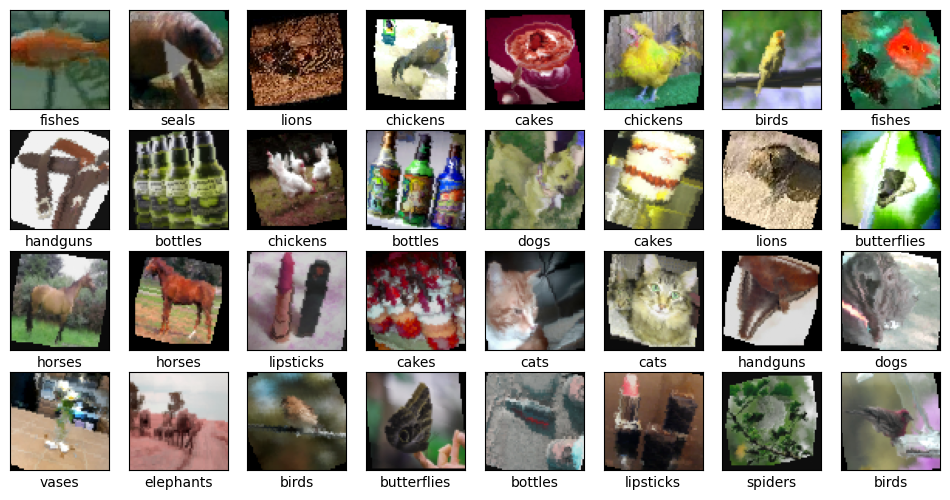

In [12]:
visualize_data(images, labels)

In [13]:
count_class = {}
for _,outs in dataset:
    labels = class_names[outs]
    if labels not in count_class:
        count_class[labels] = 0
    count_class[labels] += 1
count_class

{'birds': 512,
 'bottles': 432,
 'breads': 432,
 'butterflies': 500,
 'cakes': 432,
 'cats': 501,
 'chickens': 500,
 'cows': 500,
 'dogs': 501,
 'ducks': 496,
 'elephants': 500,
 'fishes': 500,
 'handguns': 448,
 'horses': 500,
 'lions': 500,
 'lipsticks': 400,
 'seals': 448,
 'snakes': 496,
 'spiders': 500,
 'vases': 368}

## Define Models

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
model = models.efficientnet_b3(pretrained=True)
num_classes = 20
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 128MB/s]


In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

In [21]:
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [22]:
for param in model.features.parameters():
    param.requires_grad = False

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Clear gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Loss calculation
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}')

Epoch [1/10], Loss: 2.9601410877662198
Epoch [2/10], Loss: 2.8188630533388075
Epoch [3/10], Loss: 2.7151727608514427
Epoch [4/10], Loss: 2.6352410800092163
Epoch [5/10], Loss: 2.560367732709837
Epoch [6/10], Loss: 2.530606225716262
Epoch [7/10], Loss: 2.478977893170937
Epoch [8/10], Loss: 2.4513354802046807
Epoch [9/10], Loss: 2.4214957299181576
Epoch [10/10], Loss: 2.390941702174122


In [23]:
torch.save(model.state_dict(), 'phase1_model.pth')


In [ ]:
# Unfreeze the previously frozen layers for fine-tuning
for param in model.features.parameters():
    param.requires_grad = True  # Unfreeze

# Use a lower learning rate for fine-tuning
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Continue training the whole model
num_epochs_finetune = 10  # Adjust as needed

for epoch in range(num_epochs_finetune):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Fine-tune Epoch [{epoch+1}/{num_epochs_finetune}], Loss: {running_loss/len(train_loader)}')

# Save the fully fine-tuned model
torch.save(model.state_dict(), 'fine_tuned_model.pth')

Fine-tune Epoch [1/10], Loss: 2.3583328019681775
Fine-tune Epoch [2/10], Loss: 2.2718649419601276
Fine-tune Epoch [3/10], Loss: 2.201817832807629
Fine-tune Epoch [4/10], Loss: 2.137364341270881
Fine-tune Epoch [5/10], Loss: 2.0727032690285787
Fine-tune Epoch [6/10], Loss: 2.0093405306127146
Fine-tune Epoch [7/10], Loss: 1.969610505681021


Here are some example CNNs for the demonstration purpose. You should use your own developed network for the competition.

## Training the Model

### Model Selection

#### <span style="color:#0b486b">4. Declaring the Loss, Optimizer, learning rate and Training the Model </span>

#### <span style="color:#0b486b">5. Visualizing the Performance and Loss Objective Function </span>

There are four keys in the history dictionary: `train_loss` and `val_loss` measure the loss on the training set and the validation set, respectively, while `train_acc` and `val_acc` measure the accuracy on the training set and the validation set.  
The following figure visualize all four metrics with two y-axes, losses (blue lines, in descending) and accuracies (red lines, in asending)


# Evaluate model on the testing set, get the csv file and upload to kaggle website.

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/1gntVodsAzZntMb1qW2UCns-RdpckfQh0/view?usp=sharing

Downloading...
From (original): https://drive.google.com/uc?id=1gntVodsAzZntMb1qW2UCns-RdpckfQh0
From (redirected): https://drive.google.com/uc?id=1gntVodsAzZntMb1qW2UCns-RdpckfQh0&confirm=t&uuid=ef3c97d6-9168-4d85-8e3a-3cc90e6c8df9
To: /content/test_set.zip
100% 28.9M/28.9M [00:00<00:00, 223MB/s]


In [ ]:
!unzip -q test_set.zip

In [ ]:
test_data_dir = "./test_set"

# We resize the images to [3,64,64]
transform = transforms.Compose([transforms.Resize((64,64)),  #resises the image so it can be perfect for our model.
                                      #transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                      #transforms.RandomRotation(4),     #Rotates the image to a specified angel
                                      #transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                      #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                      transforms.ToTensor(), # convert the image to tensor so that it can work with torch
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize the images, each R,G,B value is normalized with mean=0.5 and std=0.5
                                      ])


# Load the dataset using torchvision.datasets.ImageFolder and apply transformations
testset = datasets.ImageFolder(test_data_dir, transform=transform)

print("Number of instance in test_set: %s" % len(testset))

test_loader = DataLoader(testset, batch_size=500, shuffle=False)


Number of instance in test_set: 16167


In [ ]:
import torch
import pandas as pd

def save_prediction_to_csv(model, loader, device, output_file="submission.csv"):
    model.eval()
    predictions = []
    image_ids = []
    df = {
    "ID": [],
    "Label": []
    }
    total = 0
    with torch.no_grad():
        for i, (batchX, batchY) in enumerate(loader):
            batchX, batchY = batchX.to(device), batchY.to(device)
            outputs = model(batchX.float())  # Convert to float32 and feed batch to the model
            predicted = torch.argmax(outputs, dim=1)  # Get the predicted class
            total += predicted.size(0)
            for ids, pred in enumerate(predicted):
                label = class_names[pred.to(device).item()]
                df["ID"].append(i*500+ids)
                df["Label"].append(label)
    df["ID"] = [i for i in range(total)]
    # Create a DataFrame
    df = pd.DataFrame(df)
    # Save to CSV
    df.to_csv(output_file, index=False)

In [ ]:
save_prediction_to_csv(model, test_loader, device)

# Upload result to kaggle competition

## Regsiter Kaggle account using your private gmail
## Join the competition
## Upload the submission.csv file to the kaggle website to get your results